# <center> 🏭 Chat Generator 🗣️💬

---

In [1]:
!pip install -r requirements.txt -q


[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from helpers.my_functions import *

## Environment Variables 🌎

In [3]:
import os

# Set up API parameters to call the model
LLM_API_URL = os.environ.get("LLM_API_URL")
LLM_API_KEY = os.environ.get("LLM_API_KEY")
LLM_NAME = os.environ.get("LLM_NAME")

## Input Variables ✍️

In [4]:
### Enter input-variables...
print("Please, enter the following information...\n")

# project name
project_name = input("\t- project name:")

# number of iterations
iterations = int(input("\t- iterations:"))

# number of exchanges in conversation
k = int(input("\t- max number of exchanges per generated conversation:"))

Please, enter the following information...



	- project name: jurassic_lake-eng-sq
	- iterations: 100
	- max number of exchanges per generated conversation: 1


## Read `.json` config Files 📝📝

In [5]:
import json

# Function to read .json files
def read_json_files(directory_path):
    json_data = {}
    for filename in os.listdir(directory_path):
        if filename.endswith(".json"):
            file_path = os.path.join(directory_path, filename)
            with open(file_path, 'r') as file:
                value = json.load(file)
                key = filename.split(".json")[0]
                json_data[key] = value
    return json_data

# Read config files
config_path = f"projects/{project_name}/config"
configs = read_json_files(config_path)

# Read prompt files
injections_path = f"projects/{project_name}/prompting/injections"
injections = read_json_files(injections_path)

## Read `.txt` prompt and example Files 📝📝

In [6]:
# Function to read .txt files
def read_txt_files(directory_path):
    text_data = {}
    for filename in os.listdir(directory_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                value = file.read()
                key = filename.split(".txt")[0]
                text_data[key] = value
    return text_data

# Read prompt files
prompts_path = f"projects/{project_name}/prompting"
prompts = read_txt_files(prompts_path)

## ✂️ Chunk Knowledge Files ✂️

In [7]:
from tqdm import tqdm

knowledge_path = f'projects/{project_name}/knowledge/'

# Read json that maps files and chunking strtegy
json_path = f'projects/{project_name}/config/chunk-strategy.json'
with open(json_path, 'r') as file:
    chunk_config = json.load(file)

## Apply chunking strategy to every file and store results in a list
# Go through every file in knowledge base 
chunks = {}
for file in tqdm(chunk_config):
    # Get file path
    file_path = os.path.join(knowledge_path, file)
    # Get topic
    topic = os.path.dirname(file)
    # Add the topic as key in chunks dict (if not already in it)
    if topic not in chunks: chunks[topic] = []
    # Read file content
    content = read_file(file_path)
    # Divide content into chunks
    _ = chunk_text(content, **chunk_config[file])
    # Append chunks to chunks dict
    chunks[topic] += _

# Drop empty chunks
chunks = {key: [item for item in value if item] for key, value in chunks.items()}

100%|██████████| 2/2 [00:00<00:00, 518.62it/s]


## Inference Pipeline 🗣️💬

In [8]:
def make_inference(messages, temperature=0, top_p=0.5, top_k=-1, frequency_penalty=0, max_tokens=256):
    """
    messages = [
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": "Tell me a lie"}
    ]
    """
    import requests

    # Define header
    headers = {
        "Authorization": f"Bearer {LLM_API_KEY}",
        "Content-Type": "application/json"
    }

    # Define payload
    payload = {
        "model": LLM_NAME,
        "temperature": temperature,
        "top_p": top_p,
        "frequency_penalty": frequency_penalty,
        "top_k": top_k,
        "messages": messages,
        "max_tokens": max_tokens
    }

    # Send the POST request to the API
    response = requests.post(LLM_API_URL, headers=headers, json=payload)

    # Check for errors
    if response.status_code == 200:
        result = response.json()
        return result['choices'][0]['message']['content'].strip()
    else:
        print(f"Error: {response.status_code}")
        print(response.text)

In [9]:
# Test LLM API
messages = [
    {"role": "system", "content": "You are a helpful assistant"},
    {"role": "user", "content": "Tell me a lie"}
]

make_inference(messages, temperature=0, top_p=0.1, top_k=1, frequency_penalty=0, max_tokens=256)

'There is a species of jellyfish that is immortal.'

## ⚙️ Conversation Simulation ⚙️

In [10]:
### Function to process conversation templates
def process_templates(input_list):
    import re

    last_tag = None # Variable to hold the last tag
    output_list = []

    for item in input_list:
        # Remove tags between /.../
        new_item = re.sub(r'/[^/]+/', '\n', item)

        # Extract the last tag
        if re.search(r'/([^/]+)/', item):
            last_tag = re.search(r'/([^/]+)/', item).group(1)

        output_list.append(new_item)

    return output_list, last_tag

### Function to select random number between star and stop with a step (that supports floats)
def random_step_choice(start, end, step):
    import random
    numbers = [start + i * step for i in range(int((end - start) / step) + 1)]
    return random.choice(numbers)

In [11]:
%%time

from tqdm import tqdm
import random

# Generation parameters
#iterations = configs["generation-parameters"]["iterations"]

# Main loop
synthetic_data = {"system-prompt": [], "user-prompt": [], "inference-params": [], "generated-text": [], "label": []}
for iteration in tqdm(range(iterations)):
            
    ### Format system prompt template
    ## Define system injections
    system_injections = {key: random.choice(value) for key, value in injections["character"].items()}
    _ = random.choice(list(chunks.keys())) # Choose a random chunk from a random topic
    chunk = random.choice(chunks[_])
    system_injections["knowledge_base"] = chunk
        
    system_prompt = prompts["system-prompt"]
    system_prompt = system_prompt.format(**system_injections)
    
    ### Format user prompt template
    ## Define conversationa structure     
    templates = prompts["templates"].split("-"*136) # Split txt into templates based on separator: "-"*136
    template = random.choice(templates) # Randomly select a conversation template
    template = template.split("\n\n") # Split templates into exchanges
    num_exchanges = random.choice(list(range(1, k+1))) # Pick 1, 2 or ... k consecutive exchanges from the conversation template
    start_index = random.randint(0, len(template) - num_exchanges)
    sub_template = template[start_index:start_index + num_exchanges]
    sub_template, last_tag = process_templates(sub_template) # Remove all tags /.../ and save the last one 
    conversation_injections = get_random_items_from_json(injections["conversation"]) # Randomly define injections
    random_injections = get_random_items_from_json(injections["random"])
    conversation_structure = "" # Format conversation template
    for exchange in sub_template:
        conversation_structure += exchange.format(**conversation_injections).format(**random_injections) 
    user_injections = {"conversation_structure": conversation_structure}
    
    user_prompt = prompts["user-prompt"]
    user_prompt = user_prompt.format(**user_injections)    
    
    ### Generate text with LLM    
    ## Pick inference params at random
    param_ranges = configs["generation-parameters"]["inference"]
    inference_params = {key: round(random_step_choice(**param_ranges[key]),2) for key, value in param_ranges.items()}

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    generated_text = make_inference(messages, **inference_params)
    label = last_tag
    
    ### Store prompts, text and label in synthetic_data  dict (if not None)
    results = {
        "system-prompt": system_prompt,
        "user-prompt": user_prompt,
        "inference-params": inference_params,
        "generated-text": generated_text,
        "label": label
    }
    if not any(element is None for element in results.values()):
        for key, value in results.items():
            synthetic_data[key] += [value]        

print("_"*50)

100%|██████████| 100/100 [03:47<00:00,  2.27s/it]

__________________________________________________
CPU times: user 3.79 s, sys: 111 ms, total: 3.9 s
Wall time: 3min 47s


## Handwritten Examples ✍️

In [12]:
# Read handwritten examples from txt file
file_path = f"projects/{project_name}/examples/examples.txt"

with open(file_path, 'r', encoding='utf-8') as file:
    examples = file.read()

In [13]:
import pandas as pd

# Convert examples into a list
examples = examples.split("\n\n")

# Remove empty elements
examples = [e for e in examples if e]

# Split the strings into 'text' and 'label', and rep each instance n times
n = 3
cols = [(item.split(' /')[0], item.split('/')[1]) for item in examples for _ in range(n)]

# Create the df
examples_df = pd.DataFrame(cols, columns=['text', 'label'])

# Shuffle the DataFrame
examples_df = examples_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Take a look
print(examples_df)

                                 text           label
0                            Hi there  conversational
1    Make a comparative table with...  conversational
2                                 Bye  conversational
3               What are your prices?  conversational
4                        Thank youuuu  conversational
..                                ...             ...
265                            Helloo  conversational
266                     How are youuu  conversational
267                      How are you?  conversational
268          Can I ask you something?  conversational
269                           Goodbye  conversational

[270 rows x 2 columns]


In [14]:
# Add values from examples df to synthetic data dict

for idx, row in examples_df.iterrows():
    results = {
        "system-prompt": "<handwritten>",
        "user-prompt": "<handwritten>",
        "inference-params": "<handwritten>",
        "generated-text": row.text,
        "label": row.label
    }

    for key, value in results.items():
        synthetic_data[key] += [value]

## Export Files ⬇️

In [15]:
### Convert synthetic_data dict into output dict with label studio valid format

output = []
for i in range(len(synthetic_data["generated-text"])):
    # Read json file with valid output format
    file_path = f'projects/{project_name}/config/output-format.json'
    with open(file_path, 'r') as file:
        format_ = json.load(file)

    # Append generated data
    format_["id"] += i
    format_["data"]["text"] = synthetic_data["generated-text"][i]
    format_["annotations"][0]["result"][0]["value"]["choices"][0] = synthetic_data["label"][i]
    output += [format_.copy()]

In [16]:
from datetime import datetime
import pandas as pd

# Get the current time
current_datetime = datetime.now().strftime("%y-%m-%d-%Hh%Mm%Ss")

# Write generated text and labels (output dict) into .json file
file_path = f'projects/{project_name}/generated/{current_datetime}.json'
with open(file_path, 'w') as file:
    json.dump(output, file)

# Write generated text, labels and promots (synthetic_data) to .csv file
file_path = f'projects/{project_name}/generated/{current_datetime}.csv'
df = pd.DataFrame(synthetic_data)
df.to_csv(file_path, index=False)

## Take a Look 👁️

In [17]:
for i in range(10):
    label = df.loc[i]["label"]
    if label == "spam":
        bprint(df.loc[i]["generated-text"])
        bprint("-"*25)
        print(df.loc[i]["user-prompt"])
        bprint("_"*100)

User: 
Assistant: I'm sorry, I can't understand, could you repeat your question?
-------------------------
Generate a conversation between the user and the assistant with the following structure:  
  
User: <A nonsensical, repetitive, and incomprehensible message: a blank space or no text>  
Assistant: <I'm sorry, I can't understand, could you repeat your question?> 
  

IMPORTANT: The conversation must contain exactly one user query/command/comment and the corresponding assistant response. Conversations with more than one exchange are NOT allowed!
____________________________________________________________________________________________________
User: 

Assistant: I'm sorry, I can't understand, could you repeat your question?
-------------------------
Generate a conversation between the user and the assistant with the following structure:  
  
User: <A nonsensical, repetitive, and incomprehensible message: a blank space or no text>  
Assistant: <I'm sorry, I can't understand, could y

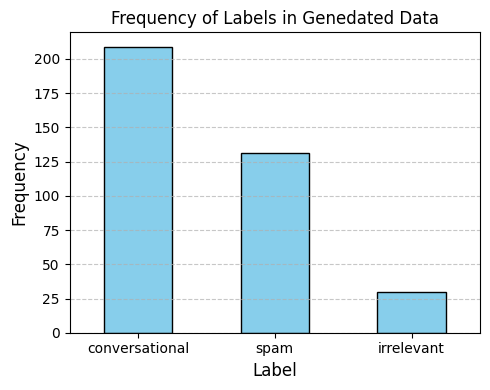

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate frequency
frequency = df["label"].value_counts()

# Create a bar plot
plt.figure(figsize=(5, 4))
frequency.plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot
plt.title(f'Frequency of Labels in Genedated Data', fontsize=12)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

---